# kNN+gzip is all you need?! 

A week ago or so I heard about this “Low-Resource” Text Classification: A Parameter-Free Classification
Method with Compressors paper (https://aclanthology.org/2023.findings-acl.426.pdf), where they claimed to beat BeRT on sentiment analysis classification. 

Once in a while, I see something and I am just compelled to try for myself, and this was one of those times. 

It has everything, it’s simple, it’s fast, it’s easy to implement, and it's my favorite machine learning algorithm, k Nearest Neighbors. I sometimes do contracting and consulting for clients, and the number of times that I've told someone that their problem doesn't need deep learning and can instead be done easier, cheaper and just as effectively, with a kNN approach, is too many to count. So, when I see something super simple like this, doing text classification for sentiment analysis with kNN for the classification and gzip with "compression distances" being used as the feature vectors, I just have to try it for myself.

The research paper came with code on github: https://github.com/bazingagin/npc_gzip, but it comes with a bunch of extra tweaks and techniques for getting the most performance, but I want something super simple and clear. I just wanted to confirm that I had a grasp on how this actually works, because this idea of compressed distances sounds simple but also a bit strange, so if you're a little fuzzy on what the heck this is, no worries because we're going to be "from scratch-ing" it here, though you should already know what k Nearest Neighbors is. I have an older tutorial on it where I built everything from scratch, if you do not know what kNN is, you can check that out here: https://pythonprogramming.net/k-nearest-neighbors-application-machine-learning-tutorial/

To get started, we'll import `gzip` for the compression, `KNeighborsClassifier` from sklearn for the classifier, and `pickle` for our dataset. I've pre-built a few datasets for simplicity.

In [36]:
import gzip
from sklearn.neighbors import KNeighborsClassifier
import pickle
import numpy as np

Next, we'll load the dataset and split it into train/test groups. I'll start us off with the 500-sample dataset to start, just to keep things running quickly.

In [2]:
N_SAMPLES = 500 

with open(f"sentiment-dataset-{N_SAMPLES}.pickle", "rb") as f:
    dataset = pickle.load(f)

train_x, train_y, test_x, test_y = dataset # samples are text strings (x) and sentiment -1 or 1 (y)

Samples are text strings paired with a label of `-1` for negative sentiment or `1` for positive sentiment. For example, we can check our first sample's text and sentiment label:

In [3]:
print(train_x[0])
print(train_y[0])

Previous reviewer Claudio Carvalho gave a much better recap of the film's plot details than I could. What I recall mostly is that it was just so beautiful, in every sense - emotionally, visually, editorially - just gorgeous.<br /><br />If you like movies that are wonderful to look at, and also have emotional content to which that beauty is relevant, I think you will be glad to have seen this extraordinary and unusual work of art.<br /><br />On a scale of 1 to 10, I'd give it about an 8.75. The only reason I shy away from 9 is that it is a mood piece. If you are in the mood for a really artistic, very romantic film, then it's a 10. I definitely think it's a must-see, but none of us can be in that mood all the time, so, overall, 8.75.
1


Machine learning models don't work with text though, we need to represent text in some way numerically instead and somehow make it a "feature" that a model could fit to. The proposal is that we compress and use NCD, or normalized compression distances. 

What's that? We want to first compress the text, something like this:

In [4]:
x_compressed = gzip.compress(train_x[0].encode())
x_compressed

b"\x1f\x8b\x08\x00C\xa5\xc4d\x02\xffUR\xbb\x8e\xdb0\x10\xfc\x95\xe9\xdc\xe8\x9cs\x11$\x01\x824W\xb9\xba\x14\x01R\xaf\xa4\x95\xb51\xc55HJ\x8a\xff>C\xda\x08\x92\x86\x12\xc9\xdd\xd9y\xf0{\xd2\xcd|\xcd\xa8_\xdd5\xe1-\xc8:\x9a\xe3M\xd2&av\\dS\x08\x96u\x98\xd1k)\xacI:\xc8\r>\xa1\xcc\x8a\xc9\xc2r\xc8\xb8\x05/\x18\xb5\x88\x85\xccs\x898c\xf05\x8cG\xfc\x9c\xa5pW\xbbB\xc0\xe2\xb9\x84;\xacU\x15X\xc1.\x19\xbf\xd6\\\x90\x9d\x13d-6\xad\xa1\x83E\xe8\xa6\xe9\x8e\xac1+^\xa0\x8b\x17\xf3H\x90{\x87\xcd\xf2\xfa\xf8\xd3\xd1\x8a'\xab\x1b\x165\xa0\x8b\xa7\x8bR\xd6\xf1k\x9f\xf0\xe1\xdbc=O\xb8\xfb\x8a`W%\t\xca}2\x90\xa4\xd8=\x8e\x9a8\x16\xc5\x11\xdc\xaf\x90\xd2A\xe2\x08\td5W\x0f\xfe\x8e\xa7\xaeX4\x96Z\xbb\xcfF_\x1aN\xa3\xde\x84%\r\xbaI$\xc2\x99W\x16\xafm\xf0nT\xdf+.A\xc6\xda\xda@\xb3j\xac5\x19\xfa\xbb$\xf14Z\x14j\xae\xa3\xd7\xb8V\x8d$\x97\xae\xd5mI\xe5?A\xef\x91\xb9d\x9a\xaa\xf5\xf6T1O\xaf\x9cy\x18q1b\xd3Z\xe9}\xe5\x1a\xf1\xf9\xf8\xe9\xe3\x11?\x98\x97G\xfa\x94T\xb2\xd7\x88\xf2\xccY\xbb\xdc1%_\xf0\xe5\xdfX\xf8\xc

Doesn't look like any number to me! Instead, we'll convert it to a number by taking the length of the compressed text:

In [5]:
x_compressed = len(gzip.compress(train_x[0].encode()))
x_compressed

451

We can't just use the size of the compressed text, because that's not normalized and easily comparable. We want to normalize it so that we can compare the distances between two compressed texts and essentially the entire dataset.

So we'd grab the length of another compressed sample:

In [6]:
x2_compressed = len(gzip.compress(train_x[1].encode())) 
x2_compressed

639

Then, we'll do this to the combined strings, so x plus x2 as `xx2`:

In [7]:
xx2 = len(gzip.compress((" ".join([train_x[0],train_x[1]])).encode()))
xx2

1024

Okay. So, we have a number, but it's not normalized, so we'll set the value to be:

The combined sample compression length minus the lesser of the two sample compressed lengths, divided by the largest of the two sample compressed lengths. Like:

In [8]:
ncd = (xx2 - min(x_compressed, x2_compressed)) / max(x_compressed, x2_compressed)
ncd

0.8967136150234741

Wonderful, looks like a number to me! Now we want to do this with every sample in the dataset, and every sample needs to be compared to every other sample, so our NCD function will look like this:

In [9]:
# NCD with compressed lengths
def ncd(x, x2):
  x_compressed = len(gzip.compress(x.encode()))
  x2_compressed = len(gzip.compress(x2.encode()))  
  xx2 = len(gzip.compress((" ".join([x,x2])).encode()))
  return (xx2 - min(x_compressed, x2_compressed)) / max(x_compressed, x2_compressed)

Now we'll compute the NCD for all training samples:

In [10]:
train_ncd = [[ncd(train_x[i], train_x[j]) for j in range(len(train_x))] for i in range(len(train_x))]

Alright, so let's see an example of a sample:

In [11]:
print(len(train_ncd[0]))
train_ncd[0]


401


[0.026607538802660754,
 0.8967136150234741,
 0.8337028824833703,
 0.844789356984479,
 0.83991683991684,
 0.8226164079822617,
 0.8969072164948454,
 0.8021505376344086,
 0.8631790744466801,
 0.8625277161862528,
 0.8048780487804879,
 0.8824833702882483,
 0.862992125984252,
 0.8520408163265306,
 0.8512544802867383,
 0.835920177383592,
 0.8603104212860311,
 0.811529933481153,
 0.8580931263858093,
 0.8755980861244019,
 0.8181818181818182,
 0.8314855875831486,
 0.9324866310160428,
 0.8489361702127659,
 0.9553372041089773,
 0.8717105263157895,
 0.8492239467849224,
 0.9112627986348123,
 0.8381374722838137,
 0.8470066518847007,
 0.8350515463917526,
 0.8425720620842572,
 0.8871866295264624,
 0.9157581764122894,
 0.835920177383592,
 0.8898963730569949,
 0.9588457899716177,
 0.8514412416851441,
 0.8217391304347826,
 0.85,
 0.8582089552238806,
 0.8536585365853658,
 0.835920177383592,
 0.8615384615384616,
 0.8292682926829268,
 0.9052734375,
 0.8625277161862528,
 0.8812392426850258,
 0.943045563549160

We have 501 total samples, we allocated 401 to training and the other 100 to testing in this case. You can see here for the first sample, all the distances are 0.8-0.9s, but we even compare it to itself, so it's extremely close. The only reason for any distance at all is how we're calculating NCD.

So each sample is a vector of 401 normalized compression distances. We'll do the same thing with the test data:


In [12]:
test_ncd = [[ncd(test_x[i], train_x[j]) for j in range(len(train_x))] for i in range(len(test_x))]

Notice that here we are calculating the normalized compression distances between the testing samples and training samples. Later, when you would go to actually deploy this into the wild so to speak, you would do the same. Every sample would be compared to every sample to build the vector of normalized compression distances.

Alright, with that, we're ready to train a classifier apparently!

As is typical with kNN, feel free to tinker with the number of neighbors. The original paper was using 2. I found 2 to be far too variable, but there are just so many factors to consider here. 

In [13]:
neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(train_ncd, train_y)

KNeighborsClassifier(n_neighbors=7)

As you can see and note by speeds, the slowest part of this algorithm is computing the NCDs. The actual kNN classification is extremely fast, especially on just 500 samples. We'll address the NCD calculation speed shortly... but how did we do?

In [14]:
print("Accuracy:", neigh.score(test_ncd, test_y))

Accuracy: 0.7029702970297029


Okay, so we're not beating BeRT, but we're not doing too bad either. We're also not using any fancy techniques, we're just using kNN with gzip compression and NCDs and 500 samples. And we did it in 25 lines of code:

In [15]:
import gzip
from sklearn.neighbors import KNeighborsClassifier
import pickle


N_SAMPLES = 500 

with open(f"sentiment-dataset-{N_SAMPLES}.pickle", "rb") as f:
    dataset = pickle.load(f)

train_x, train_y, test_x, test_y = dataset # samples are text strings (x) and sentiment -1 or 1 (y)

def ncd(x, x2): # NCD with compressed lengths
    x_compressed = len(gzip.compress(x.encode()))
    x2_compressed = len(gzip.compress(x2.encode()))  
    xx2 = len(gzip.compress((" ".join([x,x2])).encode()))
    return (xx2 - min(x_compressed, x2_compressed)) / max(x_compressed, x2_compressed)

train_ncd = [[ncd(train_x[i], train_x[j]) for j in range(len(train_x))] for i in range(len(train_x))]
test_ncd = [[ncd(test_x[i], train_x[j]) for j in range(len(train_x))] for i in range(len(test_x))]

# KNN classification
neigh = KNeighborsClassifier(n_neighbors=7) 
neigh.fit(train_ncd, train_y)
print("Accuracy:", neigh.score(test_ncd, test_y))

Accuracy: 0.7029702970297029


I want to take a moment here to really appreciate what the heck is going on. We're compressing text, and comparing those compressions and assuming that similarly-sentimented strings are going to compress with similar lengths due to statistical techniques that would be used to efficiently compress, and that's it. Essentially just common speech patterns for angry people and for happy people. That's the entire algorithm. 

I sat on this paper for a few days because I just felt like 

# it had to be wrong. 

And it was, at least in part, the author made a mistake of using k=2 and whenever there was a tie it was calculated as correct without any tie breaker. I guess he should have followed my kNN from scratch tutorial! :D

This caused a ~5% difference in accuracy, which was enough for this method to no longer beat BeRT. And my results are even worse than the papers, but this is due to my simplistic methods. The fact that with my methods we're at 70% accuracy is absolutely staggering to me. I still can't believe it and I've still sat on this for some days because I feel like it's got to be wrong still. 

What's going on here? I can logically think through why NCD might work for comparing strings in some ways, but I would still imagine with a large enough dataset, you'd have total convergence on lengths of compressions and everything would be the same distance from everything else on average. gzip is a statistically-based compression algorithm. Why would the lengths of compressions be sufficient enough to classify sentiment? It's not these normalized compression distances alone, each sample is compared essentially to every other sample as a vector and then those vectors are compared, so I suppose in some grand scheme way if there are enough similarities, the lengths will vary on average just enough by common syntax and words used to be able to classify sentiment. But still. Come on.

Accuracy does vary fairly wildy by sampled data at `500` samples, anything from 60 to 80+% depending on the chosen samples, it flattens out at `10,000` samples fairly reliably for me around the mid 70s in % accuracy. But before we show 10,000 samples, calculating NCDs linearly like this will take hours. We can do better, and we really need to. 

To begin, the starting lines through the definition of the `ncd` calc are the same, just with the import of `multiprocessing`. We'll also specify the number of processes to use, which will depend on your machine.

In [16]:
import pickle 
import gzip
from sklearn.neighbors import KNeighborsClassifier
import multiprocessing

# Number of processes to use
NUM_PROCESSES = 12 # modify based on your avail CPU cores
N_SAMPLES = 500  # 500, 1500, 5000, OR 10000 Pre-created

with open(f"sentiment-dataset-{N_SAMPLES}.pickle", "rb") as f:
    dataset = pickle.load(f)

train_x, train_y, test_x, test_y = dataset

# NCD with compressed lengths
def ncd(x, x2):
    x_compressed = len(gzip.compress(x.encode()))
    x2_compressed = len(gzip.compress(x2.encode()))  
    xx2 = len(gzip.compress((" ".join([x,x2])).encode()))
    return (xx2 - min(x_compressed, x2_compressed)) / max(x_compressed, x2_compressed)

Next, we know we want to parallelize this process, and how we might do that can vary. We are going to calculate NCD for every single sample, and for every single sample, against every sample. 

No calculation there depends on any other calculation, but it's absolutely imperative that the order of samples and the NCD "vector" for each sample is maintained. 

To do this, we'll use multiprocessing's `Pool` to calculate those NCD vector values, but if we just did this and appended the values to a list, even if we initiated the pools in order, we'd have no guarantee that the order of the samples would be maintained as some processes may finish before others.

To handle for that, we'll first initialize the NCD matrices with 0s and then update them according to indices.

In [17]:
# Initialize NCD matrices  
train_ncd = [[0] * len(train_x) for _ in range(len(train_x))]
test_ncd = [[0] * len(train_x) for _ in range(len(test_x))]

Next, we will specify a helper function that calculates the NCDs for a given sample, and then we'll use `Pool` to map that function to all samples. 

In [18]:
# Helper function to compute NCD row 
def calculate_ncd_row(data_row): # data row is a tuple of (index, text)
    i = data_row[0] # index of the data and data_row[1] is the text data
    # calcs the row of NCD values for the given data sample
    row = [ncd(data_row[1], train_x[j]) for j in range(len(train_x))]
    return i, row # return index and row's ncd values

Now we create the pool and calculate the values:

In [19]:
with multiprocessing.Pool(NUM_PROCESSES) as pool:
    # Compute train NCD
    train_data = enumerate(train_x)
    train_results = pool.map(calculate_ncd_row, train_data)
    
    # Compute test NCD
    test_data = enumerate(test_x)  
    test_results = pool.map(calculate_ncd_row, test_data)

So now we know, for each index, the vector of NCD values, so then we can populate them into those zeroed matrices:

In [20]:
# Insert rows into NCD matrices    
for i, row in train_results:
    train_ncd[i] = row
    
for i, row in test_results:
    test_ncd[i] = row

Then we can train and test the classifier:

In [21]:
# KNN classification
neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(train_ncd, train_y)

accuracy = neigh.score(test_ncd, test_y)
print("Accuracy:", accuracy)

Accuracy: 0.7029702970297029


And we can confirm that's the same accuracy as before, so it looks like our logic works. Now let's run this all together and use the `10000` sample dataset:

In [22]:
import pickle 
import gzip
from sklearn.neighbors import KNeighborsClassifier
import multiprocessing

# Number of processes to use
NUM_PROCESSES = 56
N_SAMPLES = 10000  # 500, 1500, 5000, OR 10000 Pre-created

with open(f"sentiment-dataset-{N_SAMPLES}.pickle", "rb") as f:
    dataset = pickle.load(f)

train_x, train_y, test_x, test_y = dataset

# NCD with compressed lengths
def ncd(x, x2):
  x_compressed = len(gzip.compress(x.encode()))
  x2_compressed = len(gzip.compress(x2.encode()))  
  xx2 = len(gzip.compress((" ".join([x,x2])).encode()))
  return (xx2 - min(x_compressed, x2_compressed)) / max(x_compressed, x2_compressed)

# Initialize NCD matrices  
train_ncd = [[0] * len(train_x) for _ in range(len(train_x))]
test_ncd = [[0] * len(train_x) for _ in range(len(test_x))]

# Helper function to compute NCD row 
def calculate_ncd_row(data_row):
    i = data_row[0]
    row = [ncd(data_row[1], train_x[j]) for j in range(len(train_x))] 
    return i, row

with multiprocessing.Pool(NUM_PROCESSES) as pool:
    # Compute train NCD
    train_data = enumerate(train_x)
    train_results = pool.map(calculate_ncd_row, train_data)
    
    # Compute test NCD
    test_data = enumerate(test_x)  
    test_results = pool.map(calculate_ncd_row, test_data)
    
# Insert rows into NCD matrices    
for i, row in train_results:
    train_ncd[i] = row
    
for i, row in test_results:
    test_ncd[i] = row

# KNN classification
neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(train_ncd, train_y)

accuracy = neigh.score(test_ncd, test_y)
print("Accuracy:", accuracy)

Accuracy: 0.7571214392803598


In [38]:
len(train_ncd), len(train_ncd[0])

(8001, 8001)

In [39]:
np.save('train_ndc', train_ncd)
np.save('test_ndc', test_ncd)

`75.7%` accuracy is not bad at all for such a simple method! That's very cool. It's still less accuracy than the original paper's authors, so it'd be worth looking into their methods to see what they did differently and maybe even help to inform you of some ideas about how to even further improve the method in general.

Ok, so of course the next question is, okay, how might we use such a method in practice? It's fine that we've trained a model, but how do we make a new prediction?

Essentially, it's the same as any other sample. You will take your your input string, compress it, and compare the distances to every other sample in the training set. Then we'll pass it through kNN and determine if it has more postive or negative sentiment neighbors and then we'll classify it as such. I have 2 example samples: 


Positive:
```
"I was amazed by the breathtaking beauty of the sunset at the beach. The vibrant hues of orange, pink, and gold painted the sky, creating a mesmerizing scene. It was a moment of pure serenity and joy, where I felt completely at peace and in awe of nature's wonders." 
```

Negative:
```
"I was deeply disappointed with the customer service I received from the airline. The representatives were dismissive, unprofessional, and completely indifferent to my concerns. It was a frustrating and disheartening experience that left me with a sour taste in my mouth."
```

So, for a sample, you might have it defined like:

In [23]:
new_x = "I was amazed by the breathtaking beauty of the sunset at the beach. The vibrant hues of orange, pink, and gold painted the sky, creating a mesmerizing scene. It was a moment of pure serenity and joy, where I felt completely at peace and in awe of nature's wonders." 


Then we compress:

In [24]:
new_x_compressed = len(gzip.compress(new_x.encode()))

Then we calculate the NCD vector for this sample, which is the calculation of NCDs between this sample and every other sample in the training set:

In [25]:
new_ncd = [ncd(new_x, train_x[i]) for i in range(len(train_x))]

We could multiprocess there as well, but it's fast enough for me for a single sample, and we already have the code ready and waiting for batch inference, should we desire to do more simultaneously. 

Then we can pass it through the classifier:

In [26]:
pred = neigh.predict([new_ncd])
print(pred)

[1]


So, in this case, the prediction is a positive sentiment (1 for positive, -1 for negative). Let's try the negative sentiment string:

In [27]:
new_x = "I was deeply disappointed with the customer service I received from the airline. The representatives were dismissive, unprofessional, and completely indifferent to my concerns. It was a frustrating and disheartening experience that left me with a sour taste in my mouth."
# Compress
new_x_compressed = len(gzip.compress(new_x.encode()))

# Calculate NCD
new_ncd = [ncd(new_x, train_x[i]) for i in range(len(train_x))]

# Predict 
pred = neigh.predict([new_ncd])
print(pred)

[-1]


This method, being 75% accurate only, is going to make a lot of mistakes. I also think there's probably a sweet-spot for sample string length. 

Anything that is outside the norm in length for the training data is likely to be misclassified.

In [28]:
def pred(inp):
    # Compress
    new_x_compressed = len(gzip.compress(new_x.encode()))

    # Calculate NCD
    new_ncd = [ncd(new_x, train_x[i]) for i in range(len(train_x))]

    # Predict 
    pred = neigh.predict([new_ncd])
    return pred


samps = ["It was amazing!",
         "It was terrible",
         "I loved it so much",
         "road cloud tree"]

for samp in samps:
    print(pred(samp))


[-1]
[-1]
[-1]
[-1]


Each sample here is too short to do very many "compression tricks" so they are just plain not likely to match to other samples well. We can inspect this theory of ours:

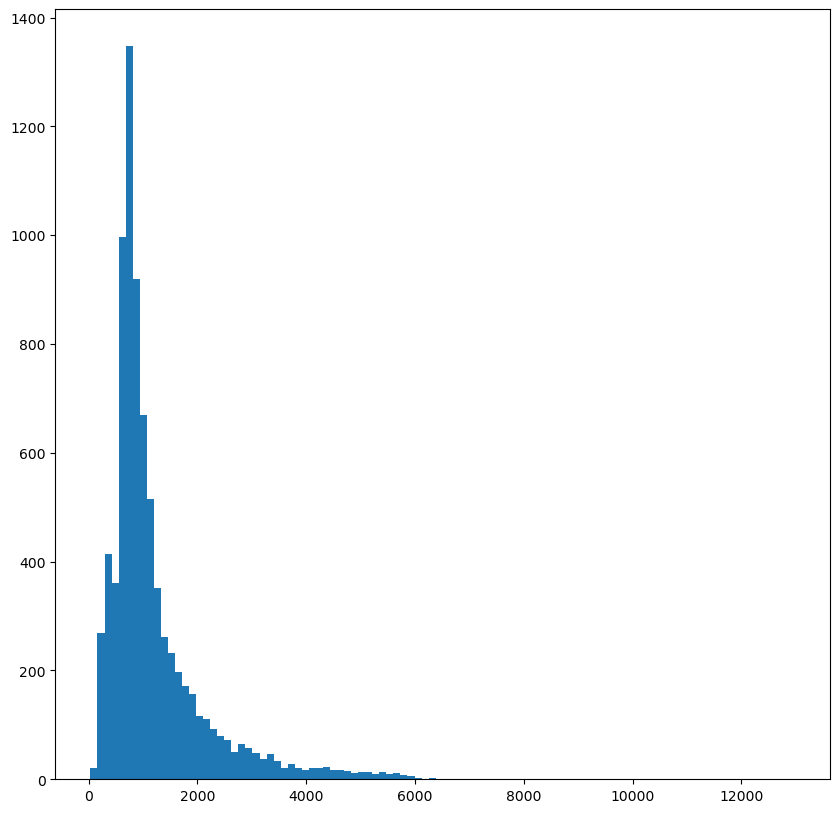

In [29]:
# calc just the length of each value in train_x to a new var called train_x_len
train_x_len = [len(x) for x in train_x]

# graph the lengths:

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
plt.hist(train_x_len, bins=100)
plt.show()



CSI person: "Enhance!"

Zooming in a bit:

<Figure size 640x480 with 0 Axes>

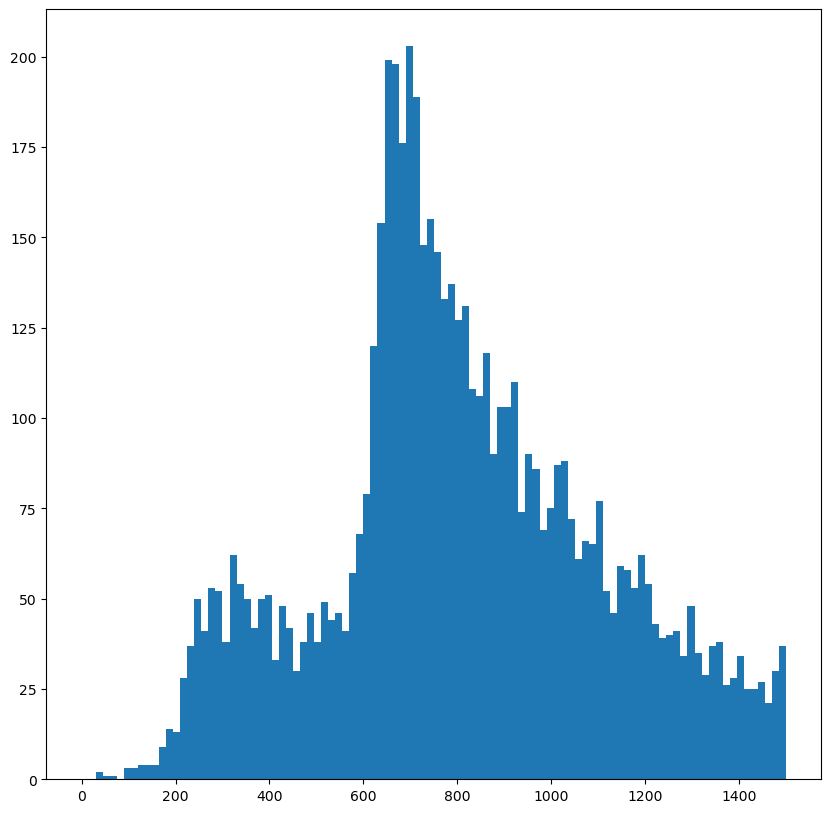

In [30]:
# same as above, but max x axis is 1500
plt.clf()
fig = plt.figure(figsize=(10, 10))
plt.hist(train_x_len, bins=100, range=(0, 1500))
plt.show()


So we can see that, at minimum, at least to go with our training set, we'd want strings likely 200+ characters, but even better at the 600+ range. If you wanted to classify shorter text, you'd want a training data set that was also shorter text, since this method is so heavily dependent on statistical compression techniques and length is playing such a pivotal role. 

I was also personally curious about PCA/TSNE and how this might look in a 2D and 3D space:

In [31]:
import numpy as np

train_ncd_arrays = np.array(train_ncd)
print(train_ncd_arrays.shape)


(8001, 8001)


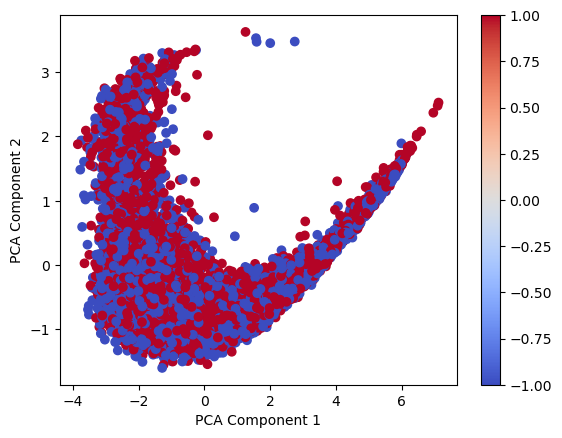

In [32]:
%matplotlib inline

# clear matplotlib figure
plt.clf()

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_ncd_arrays)

plt.scatter(train_pca[:,0], train_pca[:,1], c=train_y, cmap='coolwarm')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()

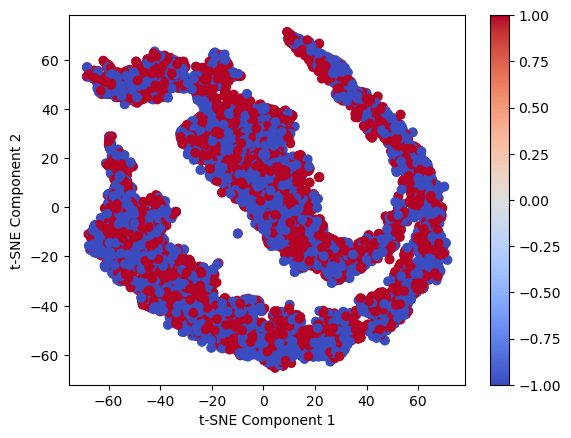

In [33]:
%matplotlib inline
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
train_tsne = tsne.fit_transform(train_ncd_arrays)

plt.scatter(train_tsne[:,0], train_tsne[:,1], c=train_y, cmap='coolwarm')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2') 
plt.colorbar()
plt.show()

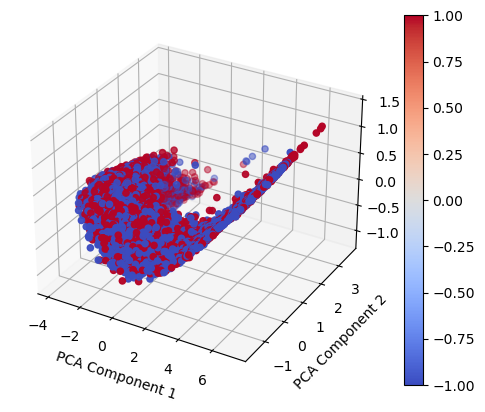

In [35]:
# %matplotlib widget

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
train_pca = pca.fit_transform(train_ncd_arrays) 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scat = ax.scatter(train_pca[:,0], train_pca[:,1], train_pca[:,2], c=train_y, cmap='coolwarm')

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')   
ax.set_zlabel('PCA Component 3')

plt.colorbar(scat)

plt.show()

I don't see any remote "alpha" with any of these methods, but apparently somewhere in those 400 (in the 500 sample case) or 8000 (in the 10K total sample example) dimensions, there is some and kNN finds it, PCA and tSNE are not really expected by me to have found something here, but I was still curious. 

Anyway, that's all for now. I hope you enjoyed this tutorial. I'm still in disbelief that this works as well as it does. Working on this brought back a lot of nostalgia for me, as NLP and kNN were some of my very first projects in programming.

This serves as a good reminder that other algorithms exist, besides just deep learning, and I would imagine this method to likely work well on other text classification problems. It is also a reminder to visit first principles once in a while. 